### PyFVCOM plotting tools examples
Plotting in three different dimensions: horizontal space, vertical space, and time.<br>
**mpl_toolkits.basemap** is deprecated and not supported.
- Load some model output into an object that can be passed to a number of plotting objects. These objects have methods for plotting different aspects of the data.
- For the horizontal plots, plotting sea surface elevations across the model domain at a given time.
- For the vertical plots, taking a transect through the water column temperature data and plot it.
- For the time plots, plotting both a simple surface elevation time series and a time-varying water column temperature plot.


In [1]:
import numpy as np
## Load an FVCOM model output and plot surface
from PyFVCOM.read import FileReader
from PyFVCOM.read import ncread
from PyFVCOM.plot import Plotter, Time, Depth
from PyFVCOM.tide import make_water_column
from PyFVCOM.grid import unstructured_grid_depths
from cmocean import cm
import matplotlib.pyplot as plt
from pyproj import Proj
import sys
import warnings
# warnings.simplefilter('ignore') # Comment out to show warnings
%matplotlib inline

No mpl_toolkits.basemap (deprecated) found in this python installation. Disable basemap. (d:\github\pyfvcom\PyFVCOM\plot.py:40)


## Check the FVCOM output NetCDF
`FileReader` instance takes long time; so better to first check dims and variables using `ncread`

In [2]:
# Activate (comment out two ''') to chack NetCDF
'''
ds = ncread('tst_0001.nc')
ds['time']
'''

"\nds = ncread('tst_0001.nc')\nds['time']\n"

## Create FVCOM model by reading FVCOM output NetCDF
Taking long time for reading a large NetCDF 
- `dims` and `variables` are optional.
- `slice` for `time` is required like `dims={item: slice(start, end, increment)}`

In [3]:
fvcom = FileReader('tst_0001.nc', dims={'time': slice(0, 50)}, variables=['zeta', 'temp', 'u'])

## Horizontal surface plotting
### Parameters for Plotter instance
        ----------
        dataset : Dataset, PyFVCOM.read.FileReader
            netCDF4 Dataset or PyFVCOM.read.FileReader object.
        stations : 2D array, optional
            List of station coordinates to be plotted ([[lons], [lats]])
        extents : 1D array, optional
            Four element numpy array giving lon/lat limits as west, east, south, north (e.g. [-4.56, -3.76, 49.96,
            50.44])
        vmin : float, optional
            Lower bound to be used on colour bar (plot_field only).
        vmax : float, optional
            Upper bound to be used colour bar (plot_field only).
        mask : float, optional
            Mask out values < mask (plot_field only).
        res : string, optional
            Resolution to use when drawing Basemap object. If None, no coastline is plotted.
        fs : int, optional
            Font size to use when rendering plot text
        title : str, optional
            Title to use when creating the plot
        cmap : string, optional
            Colormap to use when shading field data (plot_field only).
        figure : Figure, optional
            Matplotlib figure object. A figure object is created if not
            provided.
        figsize : tuple(float), optional
            Figure size in cm. This is only used if a new Figure object is
            created.
        axes : Axes, optional
            Matplotlib Axes object. An Axes object is created if not
            provided.
        axis_position : 1D array, optional
            Array giving axis dimensions
        tick_inc : list, optional
            Add coordinate axes (i.e. lat/long) at the intervals specified in
            the list ([lon_spacing, lat_spacing]).
        cb_label : str, optional
            Set the colour bar label.
        extend : str, optional
            Set the colour bar extension ('neither', 'both', 'min', 'max').
            Defaults to 'neither').
        norm : matplotlib.colors.Normalize, optional
            Normalise the luminance to 0, 1. For example, use from matplotlib.colors.LogNorm to do log plots of fields.
        m : mpl_toolkits.basemap.Basemap, optional
            Pass a Basemap object rather than creating one on each invocation.
        cartesian : bool, optional
            Set to True to skip using Basemap and instead return a simple cartesian axis plot. Defaults to False
            (geographical coordinates).
        mapper : string, optional
            Set to 'basemap' to use Basemap for plotting or 'cartopy' for cartopy.
        coast : bool, optional
            Set to True to plot coastline. Default to True.
        bmargs : dict, optional
            Additional arguments to pass to Basemap.
        axis_labels : bool, optional
            Whether to annotate x and y axis with labels (defaults to Latitude and Longitude)
        bg_color: str, optional
            sets the figure background color. Defaults to gray
        line_width: float, optional
            sets line width. If missing, uses default in rcParams
### [pcolormesh](https://matplotlib.org/stable/gallery/images_contours_and_fields/pcolormesh_levels.html)

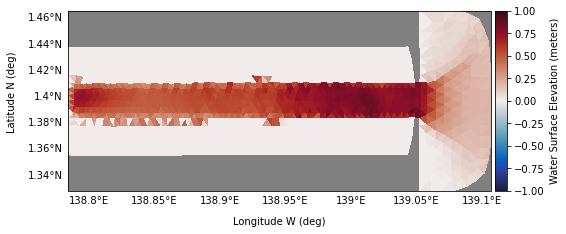

In [4]:
# Make a plot of the surface elevation.
# fvcom.data.zeta[0,:] は zetaのスライス
#   最初の次元は時間で，FileReader instanceで抽出した要素を0始まりの連続したindexとして保持
# 課題
# ・海岸線はGSHHSを使用しており，精度が悪い．陸域の塗りつぶしや海岸線の扱いは引きつづき要検討
# ・日付や任意のテキストを簡単に入れられるようにする
# ・フォントサイズ，軸ラベルの変更
# ・datetimeで抽出できるようにする

plot = Plotter(fvcom,
               figsize=(20, 20),
               res='i',
               tick_inc=(0.05, 0.02),
               cb_label='{} ({})'.format(fvcom.atts.zeta.long_name,
                                         fvcom.atts.zeta.units),
               # extents=[138.85, 139.1, 1.34, 1.44], # [w, e, s, n]
               vmin=-1.0, vmax=1.0,
               cmap=cm.balance)
plot.plot_field(fvcom.data.u[29, 0, :])  ## [time, sigma, node]
plot.figure.savefig('u_h2d.png', dpi=600, bbox_inches='tight')

#plot.cmap
#plot.axes.set_title(fvcom.time.datetime[0].strftime('%Y-%m-%d %H:%M:%S'))
#sys.exit()

### `horizontal_transect_nodes(self, poitions)`
In `PyFVCOM/grid/_grid__.py` (L:1990)<br>
        positions : np.ndarray
            -Extract node IDs along a line defined by `positions` [[x1, y1], [x2, y2], ..., [xn, yn]].
            -Array of positions along which to sample the grid. Units are spherical decimal degrees.

## Plot a `var(x, y, c)` transect between two (lon, lat) locations at a timestep.
- `fvcom`: fvcom model

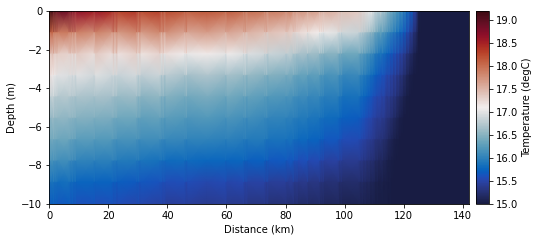

In [5]:
##### Start set parameters
timestep = 29
# lon_lat1, lon_lat2 = (138, 33), (139, 33)     ## Miwa's mesh
lon_lat1, lon_lat2 = (138.8, 1.4), (139.1, 1.4) ## Estuary example
positions = np.array((lon_lat1, lon_lat2)) ; indices, distances = fvcom.horizontal_transect_nodes(positions)
c = fvcom.data.temp[timestep, :, indices]
## colorbar label
var = 'Temperature' ; unit = 'degC'  ## Manually
# var = 'temp' ; unit = fvcom.ds.variables[var].units  ## Automatically
figsize=(20,9)
cmap=cm.balance
##### End set parameters

cb_label = ("{} ({})").format(var, unit)
png = var + '_' + 'profile.png'
x = distances / 1000  # to km from m
y = fvcom.grid.siglay_z[:, indices]

plot = Depth(fvcom, figsize=figsize, cb_label=cb_label, cmap=cmap)
## fill_seabed makes the part of the plot below the seabed gray.
plot.plot_slice(x, y, c, fill_seabed=True, shading='gouraud')
#plot.plot_slice(x, y, c, fill_seabed=True, edgecolors='white')
plot.axes.set_xlim(right=x.max())  # set the x-axis to the data range
plot.axes.set_xlabel('Distance (km)')
plot.axes.set_ylabel('Depth (m)')
## Save the figure.
plot.figure.savefig(png, dpi=600, bbox_inches='tight')
# sys.exit()

## Plot a time serie at a specific location
### `Time.plotline()`

295


Text(0, 0.5, 'Water Surface Elevation (meters)')

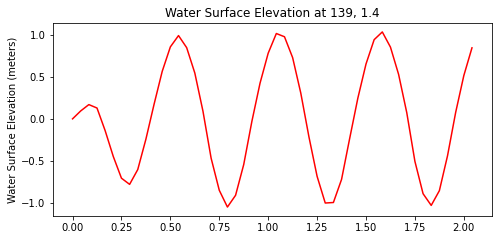

In [6]:
# ・x軸のself.timeは要datetimeのため，現在はNoneになっている，
gauge = (139, 1.4)  # a sample (lon, lat) position for Estuary example
index = fvcom.closest_node(gauge).item()  ### narray.item(): -> scalar
print(index)
time = Time(fvcom, figsize=(20, 9), title='{} at {}, {}'.format(fvcom.atts.zeta.long_name,
                                                                *gauge))
time.plot_line(fvcom.data.zeta[:, index], color='r')
time.axes.set_ylabel('{} ({})'.format(fvcom.atts.zeta.long_name,
                                      fvcom.atts.zeta.units))

## Plot a depth-varying time profile through a water column at a specific location

The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh. (d:\github\pyfvcom\PyFVCOM\plot.py:443)


Text(0, 0.5, 'Depth (m)')

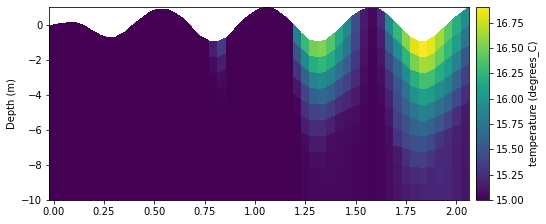

In [7]:
gauge = (139, 1.4)  # a sample (lon, lat) position for Estuary example
index = fvcom.closest_node(gauge).item()  ### ndarray -> scalar
# print(index) # 295
fvcom = FileReader('tst_0001.nc', variables=['zeta', 'temp'], dims={'time': slice(0,50), 'node': index})
time = Time(fvcom, figsize=(20, 9), cb_label='{} ({})'.format(fvcom.atts.temp.long_name,
                                                              fvcom.atts.temp.units))
z = unstructured_grid_depths(fvcom.grid.h, fvcom.data.zeta, fvcom.grid.siglay)
## print("z.shape", z.shape)
## fill_seabed makes the part of the plot below the seabed grey.
## We need to squeeze the data array since we've only extracted a single position.
## print(fvcom.grid.h.shape)
## print(fvcom.grid.h)
time.plot_surface(z, fvcom.data.temp, fill_seabed=True, h_offset=0, h_min=fvcom.grid.h)
time.axes.set_ylabel('Depth (m)')